In [1]:
import torch
from PIL import Image
from transformers import AutoModel
from huggingface_hub import hf_hub_download
from torchvision.transforms import functional as F
from pathlib import Path

In [2]:
def load_image(img_path):
    img = Image.open(img_path).convert("RGB")
    # Resize the image to have a fixed height of 64 pixels
    img = img.resize((img.width * 64 // img.height, 64))
    img = F.to_tensor(img)
    img = F.normalize(img, [0.5], [0.5])
    return img

In [3]:
def load_style_image(path, device):
    img = Image.open(path).convert("RGB")
    # example: resize to height 64 like in the Emuru docs (you can adjust)
    img = img.resize((img.width * 64 // img.height, 64))
    t = F.to_tensor(img)
    t = F.normalize(t, [0.5], [0.5])   
    t = t.unsqueeze(0)             
    return t.to(device)

In [4]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

model = AutoModel.from_pretrained(
    "blowing-up-groundhogs/emuru",
    trust_remote_code=True
).to(device)
model.eval()

Using MPS


Emuru(
  (T5): T5ForConditionalGeneration(
    (shared): Embedding(384, 1024)
    (encoder): T5Stack(
      (embed_tokens): Embedding(384, 1024)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=1024, out_features=1024, bias=False)
                (k): Linear(in_features=1024, out_features=1024, bias=False)
                (v): Linear(in_features=1024, out_features=1024, bias=False)
                (o): Linear(in_features=1024, out_features=1024, bias=False)
                (relative_attention_bias): Embedding(32, 16)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=1024, out_features=4096, bias=False)
                (wo): Linear(in_features=

In [5]:
PROJECT_ROOT = Path.home() / "projects" / "handwriting_forge_project"
# iam_metadata_path = PROJECT_ROOT/"data"/"processed"/"metadata"/"iam_metadate.csv"
iam_metadata_path = Path("/Users/adnanatif/projects/handwriting_forge_project/data/processed/metadata/iam_metadata.csv")

In [6]:
import pandas as pd

# Load CSV file into a DataFrame
iam_df = pd.read_csv(iam_metadata_path)
print(iam_df.head())

                     filepath source    label  \
0  data/raw/iam/iam_00000.png    iam  genuine   
1  data/raw/iam/iam_00001.png    iam  genuine   
2  data/raw/iam/iam_00002.png    iam  genuine   
3  data/raw/iam/iam_00003.png    iam  genuine   
4  data/raw/iam/iam_00004.png    iam  genuine   

                                       text  idx  
0      put down a resolution on the subject    0  
1        and he is to be backed by Mr. Will    1  
2     nominating any more Labour life Peers    2  
3       M Ps tomorrow. Mr. Michael Foot has    3  
4  Griffiths, M P for Manchester Exchange .    4  


Powerful units have stood firm .


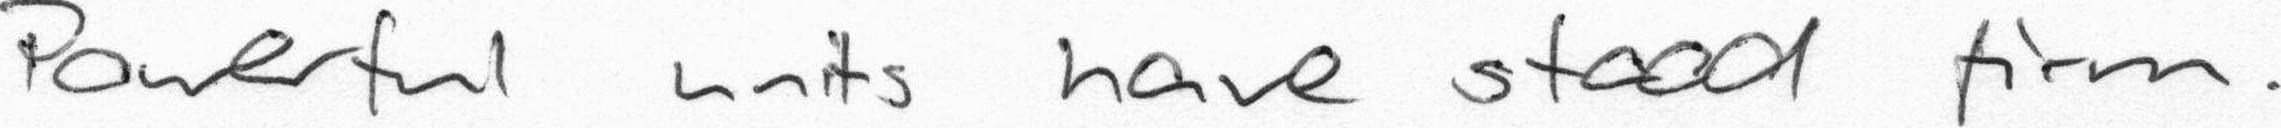

In [7]:
from IPython.display import display

sample_row = iam_df.sample(1).iloc[0]
print(sample_row["text"])
display(Image.open(PROJECT_ROOT / sample_row["filepath"]))

In [8]:
style_text = 'Hand written text'
gen_text = 'the young Mercer in a'
img_path = hf_hub_download(repo_id="blowing-up-groundhogs/emuru", filename="sample.png")
# style_img = load_image(PROJECT_ROOT / sample_row["filepath"])
style_img = load_style_image(PROJECT_ROOT / sample_row["filepath"],device)

In [9]:
style_img

tensor([[[[ 0.8353,  0.6392,  0.4824,  ...,  0.9686,  0.9451,  0.9373],
          [ 0.4118, -0.0588, -0.0824,  ...,  0.9765,  0.9686,  0.9608],
          [-0.0745, -0.2863, -0.1765,  ...,  0.9529,  0.9686,  0.9686],
          ...,
          [ 0.9843,  0.9843,  0.9686,  ...,  0.9686,  0.9686,  0.9686],
          [ 0.9765,  0.9765,  0.9608,  ...,  0.9765,  0.9686,  0.9608],
          [ 0.9686,  0.9686,  0.9608,  ...,  0.9843,  0.9686,  0.9529]],

         [[ 0.8353,  0.6392,  0.4824,  ...,  0.9686,  0.9451,  0.9373],
          [ 0.4118, -0.0588, -0.0824,  ...,  0.9765,  0.9686,  0.9608],
          [-0.0745, -0.2863, -0.1765,  ...,  0.9529,  0.9686,  0.9686],
          ...,
          [ 0.9843,  0.9843,  0.9686,  ...,  0.9686,  0.9686,  0.9686],
          [ 0.9765,  0.9765,  0.9608,  ...,  0.9765,  0.9686,  0.9608],
          [ 0.9686,  0.9686,  0.9608,  ...,  0.9843,  0.9686,  0.9529]],

         [[ 0.8353,  0.6392,  0.4824,  ...,  0.9686,  0.9451,  0.9373],
          [ 0.4118, -0.0588, -

In [10]:
import time

start = time.perf_counter()

generated_pil_image = model.generate(
    style_text=style_text,
    gen_text=gen_text,
    style_img=style_img,
    max_new_tokens=256
)

end = time.perf_counter()
print(f"Time for one image: {end - start:.2f} seconds")


Time for one image: 154.00 seconds


In [ ]:
generated_pil_image